# План работы

### 1. Подготовка данных
Загрузка данных, проверка данных на пропуски.

### 2. Анализ данных
Исследование изменения концентраций частиц на разных стадиях. Сравнение типов сырья в тестовой и тренировочной выборках. Удаление аномальных данных.

### 3. Подбор модели
Подготовка данных для машинного обучения. Выбор оптимальной модели из линейной регрессии, решающего дерева и случайного леса. Подбор гиперпараметров. Тестирование оптимальной модели и сравнение с константной.

# Данные

В наличие были данные о параметрах для двух стадий технологического процесса - флотации и очистки.

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data_train = pd.read_csv('../gold/gold_recovery_train.csv')
data_test = pd.read_csv('../gold/gold_recovery_test.csv')
data_full = pd.read_csv('../gold/gold_recovery_full.csv')

print('Тренировочная выборка')
print(data_train.info())
print()
print('Тестовая выборка')
print(data_test.info())
print()
print('Полная выборка')
print(data_full.info())

Тренировочная выборка
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16

В данных присутствуют пропуски. Кроме того, в таблице с тестовой выборкой данных меньше столбцов.

In [2]:
import warnings
warnings.filterwarnings('ignore')

data_train_temp = data_train.dropna(subset=['rougher.output.recovery'])

def count_rougher_output_recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    if f*(c-t)==0:
        return 0
    recovery = (c*(f-t))/(f*(c-t))*100
    return 0 if recovery<0 or recovery>100 else recovery
data_train_temp['rougher.output.recovery_counted']=data_train_temp.apply(count_rougher_output_recovery, axis=1)

from sklearn.metrics import mean_squared_error as mse
print(mse(data_train_temp['rougher.output.recovery'], data_train_temp['rougher.output.recovery_counted']))

2.0435431534920925e-28


Проверим правильность расчётов rougher.output.recovery, предварительно удалив из выборки все пропуски в рассчитываемом столбце. Эффективность обогащения для этого признака рассчитана правильно, так как MSE близка к нулю.

In [3]:
print('Столбцы, отсутствующие в тестовом датасете:')
print(set(data_train.columns) - set(data_test.columns))

Столбцы, отсутствующие в тестовом датасете:
{'final.output.concentrate_ag', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'secondary_cleaner.output.tail_au', 'final.output.tail_au', 'rougher.output.concentrate_ag', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_pb', 'rougher.output.tail_au', 'primary_cleaner.output.tail_au', 'final.output.tail_pb', 'rougher.output.tail_pb', 'final.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_pb', 'rougher.output.concentrate_pb', 'rougher.output.recovery', 'rougher.output.tail_ag', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'final.output.concentrate_pb', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_sol', 'rougher.output.concentrate_sol', 'final.output.recovery', 'primary_c

Все отсутствующие в тестовом датасете значения относятся либо к расчётным характеристикам, либо к выходным характеристикам.

In [4]:
data_train['date'] = pd.to_datetime(data_train['date'], format = '%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format = '%Y-%m-%d %H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format = '%Y-%m-%d %H:%M:%S')

array_of_nan_to_drop = (list(data_full.loc[data_full['rougher.output.recovery'].isnull()]['date'])
                       +list(data_full.loc[data_full['final.output.recovery'].isnull()]['date'])
                       )

data_test = data_test[~data_test['date'].isin(array_of_nan_to_drop)].reset_index()
data_train = data_train.dropna(subset=['rougher.output.recovery','final.output.recovery'])
data_full = data_full.dropna(subset=['rougher.output.recovery','final.output.recovery'])

def fill_emptyness(data):
    for name in data.columns[1:]:
        string = name.split('.')
        if 'calculation' in string:
            data[name].fillna(0, inplace=True)
            
        if 'input' in string and 'feed' not in string[2].split('_'):
            data[name].fillna(0, inplace=True)
            
        if 'output' in string or 'input' in string or 'state' in string:
            data[name].fillna(method='ffill', inplace=True)

fill_emptyness(data_train)
fill_emptyness(data_test)
fill_emptyness(data_full)

print('Тренировочная выборка')
print(data_train.info())
print()
print('Тестовая выборка')
print(data_test.info())
print()
print('Полная выборка')
print(data_full.info())

Тренировочная выборка
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14149 non-null  float64       
 2   final.output.concentrate_pb                         14149 non-null  float64       
 3   final.output.concentrate_sol                        14149 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14149 non-null  floa

Предположим, что пропуски можно разделить на две группы. Во-первых, пропуски в столбцах, где подразумевался ноль вместо пропуска. Это можно отнести к столбцам с рассчитанными параметрами (calculation) и к столбцам с концентрацией реагентов. Вторая группа это пропуски с выходными данными, либо с параметрами смеси, либо с данными, касающимися загрузки исходного сырья - здесь пропуск логично заполнить предыдущим значением, так как по условию данные, взятые с небольшим временным промежутком, почти не отличаются друг от друга. Заполним пропуски в соответствие с этим предположением. Что касается пропусков в столбцах recovery, то их природа неизвестна, а заполнять их нулями или предыдущими значениями рискованно, есть шанс, что это может увеличить расхождение с предсказаниями модели. Поэтому логичнее всего представляется их удалить.

## Вывод

Большинство пропусков, за исключением recovery, можно заполнить (либо нулями, либо предыдущими значениями). В тестовой выборке отсутствуют данные по выходным концентрациям, следовательно, для модели необходими использовать только входные данные и данные с концентрациями реагентом, что, впрочем, представляется логичным.

# 2. Анализ данных

Cредняя концентрация металла золото на этапе rougher_input равна 8.27
Cредняя концентрация металла золото на этапе rougher_output равна 19.77
Cредняя концентрация металла золото на этапе primary_output равна 32.12
Cредняя концентрация металла золото на этапе final_output равна 44.08


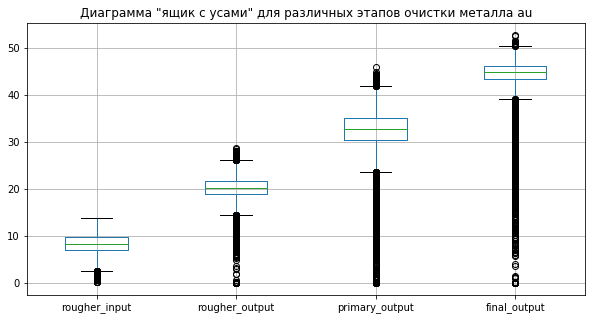

Cредняя концентрация металла серебро на этапе rougher_input равна 8.79
Cредняя концентрация металла серебро на этапе rougher_output равна 11.99
Cредняя концентрация металла серебро на этапе primary_output равна 8.44
Cредняя концентрация металла серебро на этапе final_output равна 5.17


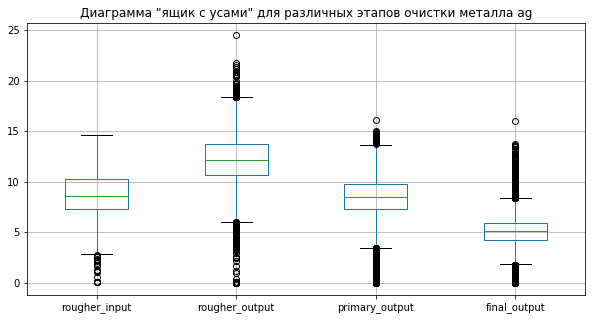

Cредняя концентрация металла свинец на этапе rougher_input равна 3.59
Cредняя концентрация металла свинец на этапе rougher_output равна 7.61
Cредняя концентрация металла свинец на этапе primary_output равна 9.81
Cредняя концентрация металла свинец на этапе final_output равна 9.98


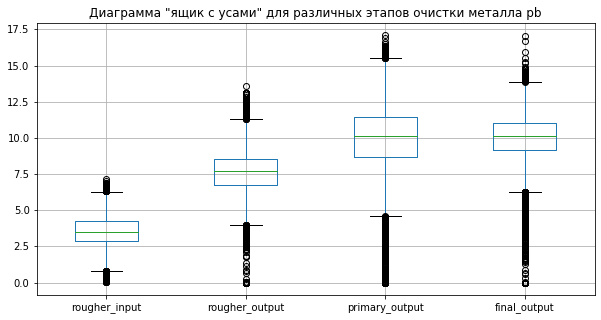

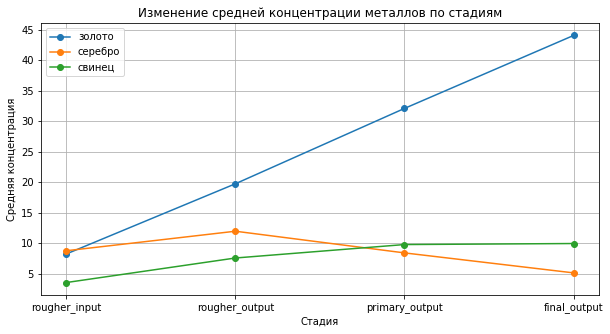

In [5]:
element_mean_array = []
element_dict = {'au':'золото',
                'ag':'серебро',
                'pb':'свинец'}
for element in 'au','ag','pb':
    rougher_input = 'rougher.input.feed_' + element
    rougher_output = 'rougher.output.concentrate_' + element
    primary_output = 'primary_cleaner.output.concentrate_' + element
    final_output = 'final.output.concentrate_' + element
    data_temp = data_full[[rougher_input,rougher_output,primary_output, final_output]]
    data_temp.columns = ['rougher_input','rougher_output','primary_output','final_output']
    
    mean_array = []
    for i in data_temp.columns:
        print('Cредняя концентрация металла', element_dict[element],
              'на этапе', i, 'равна {:.2f}'.format(data_temp[i].mean()))
        mean_array.append(data_temp[i].mean())
        
    element_mean_array.append(mean_array)
    data_temp.boxplot(figsize=(10,5))
    plt.title('Диаграмма "ящик с усами" для различных этапов очистки металла '+element)
    plt.show()
    
fig, ax = plt.subplots()
for i in element_mean_array:
    ax.plot(['rougher_input','rougher_output','primary_output','final_output'], i, marker = 'o')

fig.set_figwidth(10)
fig.set_figheight(5)
plt.title('Изменение средней концентрации металлов по стадиям')
plt.ylabel('Средняя концентрация')
plt.xlabel('Стадия')
plt.grid(True)
ax.legend(element_dict.values())

Построим диаграммы вида "ящик с усами" для отображения распределения концентраций каждого металла на каждой стадии. Видно, что средняя концентрация золота увеличивается, при этом для каждой следующей стадии характере всё более длинный "хвост" в сторону низких концентраций, что позволяет предположить, что очистка не всегда проходит успешно. Общий график средних концентраций показывает, что в относительных цифрах содержание золота увеличивается более чем в четыре раза, в то время как содержание других металлов не поднимается выше 10%.

Средний размер гранул сырья 60.24 (медиана 55.27), с дисперсией 529.24 и стандартным отклонением 23.00
Средний размер гранул сырья 55.95 (медиана 50.85), с дисперсией 364.06 и стандартным отклонением 19.08


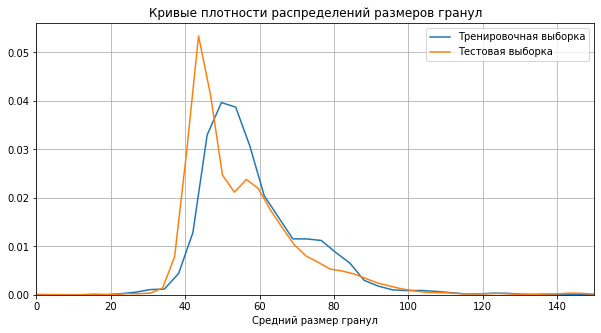

In [6]:
import numpy as np
import seaborn as sns
from scipy import stats as st

fig,ax = plt.subplots()
plot_dict = {'Тренировочная выборка': data_train['rougher.input.feed_size'],
             'Тестовая выборка': data_test['rougher.input.feed_size']}

for i in plot_dict:
    feed_size = plot_dict[i]
    print('Средний размер гранул сырья {:.2f}'.format(feed_size.mean()),
      '(медиана {:.2f}),'.format(feed_size.median()),
      'с дисперсией {:.2f}'.format(np.var(feed_size, ddof=1)),
      'и стандартным отклонением {:.2f}'.format(np.std(feed_size)))
    sns.distplot(feed_size, hist=False, kde=True, label=i)

fig.set_figwidth(10)
fig.set_figheight(5)
plt.xlabel('Средний размер гранул')
plt.title('Кривые плотности распределений размеров гранул')
plt.xlim(0,150)
plt.grid(True)

Кривые плотности распределения размеров гранул сырья показывают, что форма распределений практически совпадают. Рассчитанные значения среднего, медианы и дисперсии также близки друг к другу, следовательно, вероятнее всего, модель, обученную на тренировочной выборке, можно будет применять к тестовой.

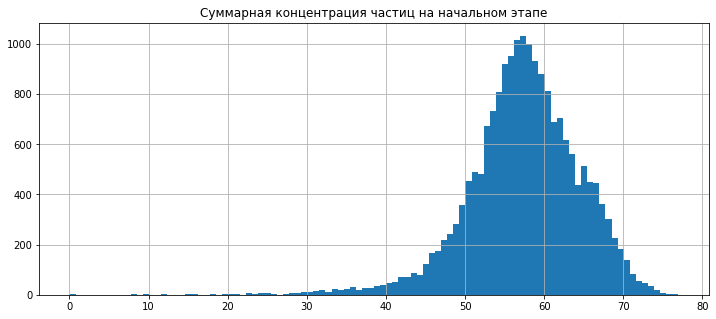

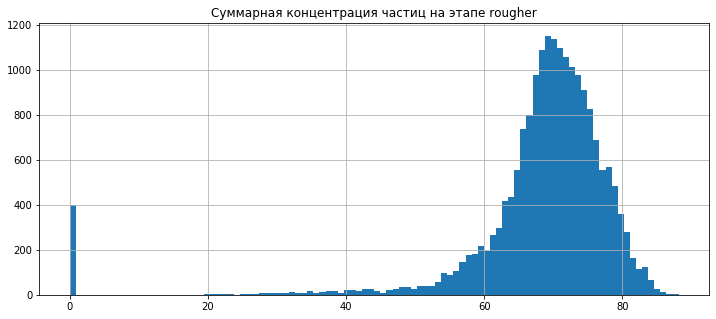

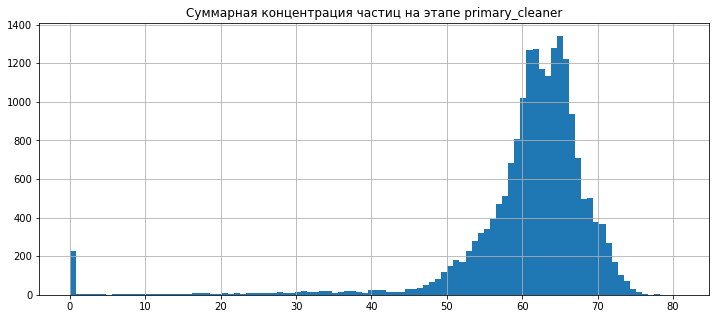

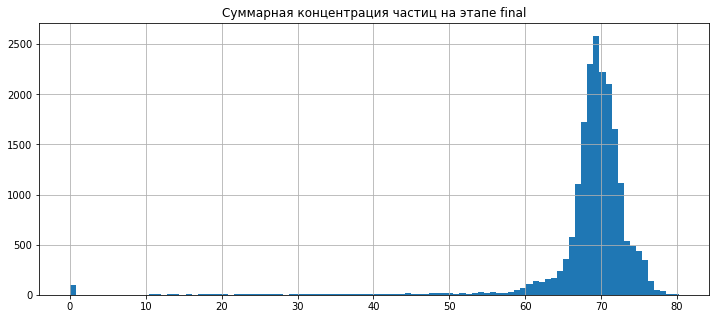

In [7]:
def build_graphics():
    arr = [0]*len(data_full)

    data_full['input_sum'] = arr
    for j in 'ag','pb','sol','au':
        name = 'rougher.input.feed_'+j
        data_full['input_sum'] += data_full[name]
    data_full['input_sum'].hist(bins=100, figsize=(12,5))
    plt.title('Суммарная концентрация частиц на начальном этапе')
    plt.show()

    for i in 'rougher','primary_cleaner','final':
        summ = i+'_sum'
        data_full[summ] = arr
        for j in 'ag','pb','sol','au':
            name = i+'.output.concentrate_'+j
            data_full[summ] += data_full[name]
        data_full[summ].hist(bins=100, figsize=(12,5))
        plt.title('Суммарная концентрация частиц на этапе '+i)
        plt.show()

build_graphics()

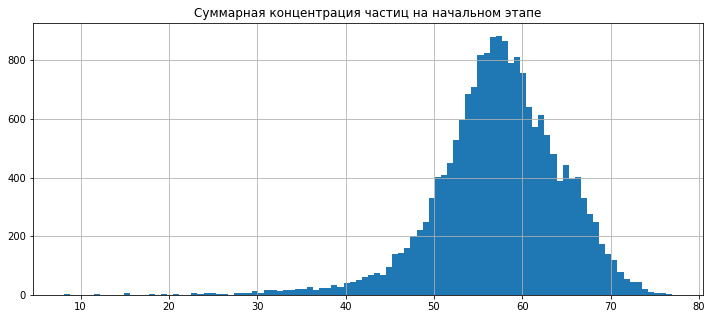

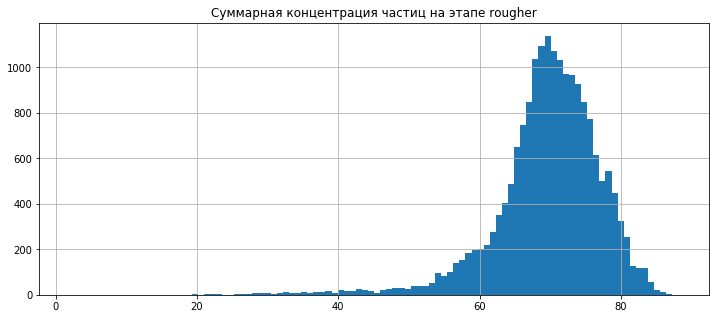

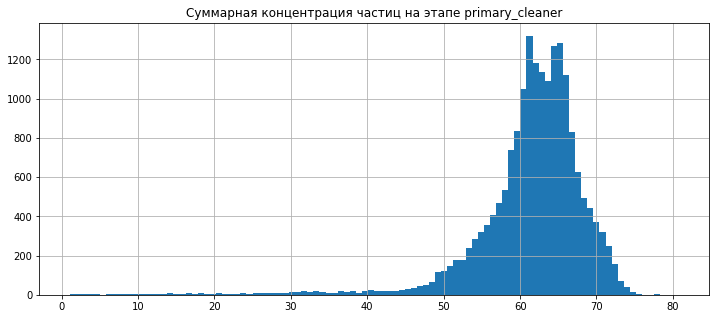

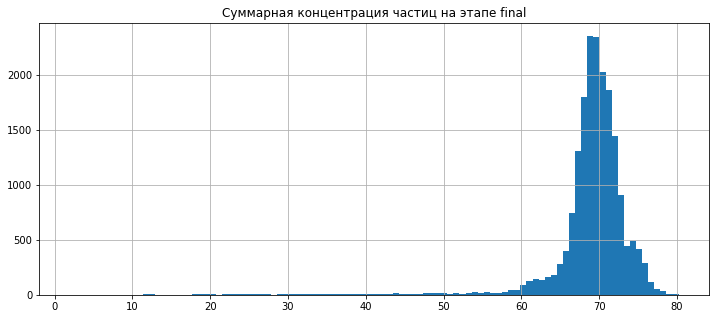

In [8]:
array_of_date_to_drop = []
for i in 'input_sum','rougher_sum','final_sum','primary_cleaner_sum':
    array_of_date_to_drop += list(data_full[data_full[i]<1]['date'])

data_test = data_test[~data_test['date'].isin(array_of_date_to_drop)].reset_index()
data_train = data_train[~data_train['date'].isin(array_of_date_to_drop)].reset_index()
data_full = data_full[~data_full['date'].isin(array_of_date_to_drop)].reset_index()

build_graphics()

Построение распределения суммарной концентрации металлов показывает, что в данных присутствуют аномалии - околонулевая суммарная концентрация металлов. Их необходимо удалить. Повторное построение графиков показывает, что пропуски удалены.

## Вывод

Анализ данных показывает, что, во-первых, средняя концентрация золота растёт более чем в 4 раза и процесс очищения происходит. Во-вторых, данные из тестовой и тренировочной выборок имеют приблизительно одинаковое распределение, что позволит нам использовать одну и ту же модель на обеих выборках. В-третьих, благодаря анализу были обнаружены и удалены аномалии из данных (суммарная концентрация веществ равна нулю).

# 3. Модель

In [9]:
features_rougher_arr = []
features_final_arr = []
for i in data_train.columns:
    if i!='date':
        column = i.split('.')
        if 'output' not in column and 'calculation' not in column:
            if 'rougher' in column:
                features_rougher_arr.append(i)
            features_final_arr.append(i)

train_features_rougher = data_train[features_rougher_arr]
train_target_rougher = data_train['rougher.output.recovery']
train_features_final = data_train[features_final_arr]
train_target_final = data_train['final.output.recovery']

test_features_rougher = data_test[features_rougher_arr]
test_target_rougher = data_test.merge(data_full[['date','rougher.output.recovery']], on='date')['rougher.output.recovery']
test_features_final = data_test[features_final_arr]
test_target_final = data_test.merge(data_full[['date','final.output.recovery']], on='date')['final.output.recovery']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_features_rougher = pd.DataFrame(scaler.fit_transform(train_features_rougher), columns=features_rougher_arr)
test_features_rougher = pd.DataFrame(scaler.transform(test_features_rougher), columns=features_rougher_arr)

train_features_final = pd.DataFrame(scaler.fit_transform(train_features_final), columns=features_final_arr)
test_features_final = pd.DataFrame(scaler.transform(test_features_final), columns=features_final_arr)

Разделим данные на выборки. Для модели, предсказывающей rougher.output.recovery, выберем те признаки, которые присутствуют в тестовой выборке и относятся к загрузке сырья и условий в реакторе на стадии rougher, для модели, предсказывающей final.output.recovery - признаки, относящиеся ко всем стадиям. Затем стандартизируем данные.

In [11]:
def smape_calc(targ, pred):
    '''
    функция для расчёта smape
    '''
    data_temp=abs(targ-pred)*2/(abs(targ)+abs(pred))
    return data_temp.mean()

def cross_val(model, number=5):
    '''
    функция для кросс-валидации
    '''
    sample_size = int(len(train_features_rougher)/number)
    scores = []
    
    for i in range(0, len(train_features_rougher), sample_size):
        valid_indexes = train_features_rougher.iloc[i: i + sample_size].index
        train_indexes = (train_features_rougher.iloc[:i] + train_features_rougher.iloc[i + sample_size:]).index
        
        smapes=[] #в массиве будет на первом месте smape для этапа rougher
                  #на втором месте smape для этапа final
        features_arr = [train_features_rougher, train_features_final]
        target_arr = [train_target_rougher, train_target_final]
        
        for x,y in zip(features_arr, target_arr):
            features_train = x.iloc[train_indexes]
            features_valid = x.iloc[valid_indexes]
            target_train = y.iloc[train_indexes]
            target_valid = y.iloc[valid_indexes]
            model.fit(features_train, target_train)
            prediction = model.predict(features_valid)
            smape = smape_calc(target_valid, prediction)
            smapes.append(smape)
        
        smape_final = 0.25*smapes[0]+0.75*smapes[1]
        scores.append(smape_final)
    
    return sum(scores)/len(scores)

from sklearn.linear_model import LinearRegression
lr_smape = cross_val(LinearRegression())

print("Линейная регрессия")
print("Значение sMAPE {:.2%}".format(lr_smape))

Линейная регрессия
Значение sMAPE 8.42%


In [12]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_smape = []

for i in range(2,11):
    model = DecisionTreeRegressor(max_depth=i, random_state = 1)
    model_smape = cross_val(model)
    decision_tree_smape.append(model_smape)

print("Решающее дерево")
print("Минимальное значение sMAPE {:.2%}".format(min(decision_tree_smape)),"для глубины дерева",
     decision_tree_smape.index(min(decision_tree_smape))+2)

Решающее дерево
Минимальное значение sMAPE 7.80% для глубины дерева 3


In [13]:
from sklearn.ensemble import RandomForestRegressor

random_forest_smape = []
for i in range(10,51,10):
    model = RandomForestRegressor(max_depth=3, n_estimators=i, random_state=1)
    model_smape = cross_val(model)
    random_forest_smape.append(model_smape)

print("Случайный лес") 
print("Минимальное значение метрики sMAPE {:.2%}".format(min(random_forest_smape)),"для числа деревьев",
     10*random_forest_smape.index(min(random_forest_smape))+10)

Случайный лес
Минимальное значение метрики sMAPE 7.42% для числа деревьев 30


Перебор разных моделей с применением кросс-валидации показывает, что оптимальной моделью является случайный лес, так как ошибка в прогнозах минимальна. Применим её к тестовому датасету. 

In [14]:
model = RandomForestRegressor(max_depth=3, n_estimators=30, random_state=1)
model.fit(train_features_rougher, train_target_rougher)
prediction_rougher = model.predict(test_features_rougher)
const_prediction_rougher = pd.Series(train_target_rougher.mean(), index=test_target_rougher.index)
smape_rougher = smape_calc(test_target_rougher, prediction_rougher)
const_smape_rougher = smape_calc(test_target_rougher, const_prediction_rougher)

model = RandomForestRegressor(max_depth=3, n_estimators=30, random_state=1)
model.fit(train_features_final, train_target_final)
prediction_final = model.predict(test_features_final)
const_prediction_final = pd.Series(train_target_final.mean(), index=test_target_final.index)
smape_final = smape_calc(test_target_final, prediction_final)
const_smape_final = smape_calc(test_target_final, const_prediction_final)

smape_test = 0.25*smape_rougher+0.75*smape_final
const_smape_test = 0.25*const_smape_rougher+0.75*const_smape_final
print("Итоговая SMAPE для модели дерева решений: {:.2%}".format(smape_test))
print("Итоговая SMAPE для константной модели (предсказывает среднее): {:.2%}".format(const_smape_test))

Итоговая SMAPE для модели дерева решений: 7.35%
Итоговая SMAPE для константной модели (предсказывает среднее): 7.78%


Метрика sMAPE для модели дерева решений, обученной на тренировочном датасете, равна 7.35%, что немногим меньше, чем метрика sMAPE для константной модели, предсказывающей среднее. 

## Вывод

Лучшая из всех моделей показывает метрику sMAPE, равную 7.35%, что лишь на полпроцента меньше, чем sMAPE константной модели (7.78%). Это означает, что при использовании машинного обучения для улучшения степени очистки золота эффективность процесса будет лишь немногим выше, чем без использования, следовательно, внедрение машинного обучения в данный технологический процесс может оказаться неоправданным, если затраты на него превысят возможную крайне малую выгоду.